In [2]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=9d35d1aba2853ac2bb5e3702f219a19d50abe5e5088507307be2d70d8704840d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=2c3f557

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
seed = 42
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(seed)

In [6]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
mkdir ~/.kaggle

In [9]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download franciscoescobar/satellite-images-of-water-bodies

 94% 233M/247M [00:02<00:00, 116MB/s] 
100% 247M/247M [00:02<00:00, 109MB/s]


In [11]:
! unzip satellite-images-of-water-bodies.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body

In [13]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(p = 0.5), 
            A.VerticalFlip(p = 0.5), 
            A.RandomRotate90(p = 0.5),
            A.RandomBrightnessContrast(p = 0.5)
            ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L') #single channel image - normally interpreted as greyscale
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [14]:
from sklearn.model_selection import train_test_split

base_path = "Water Bodies Dataset"
images = sorted(glob.glob('Water Bodies Dataset/Images/*'))
masks = sorted(glob.glob('Water Bodies Dataset/Masks/*'))

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=seed)

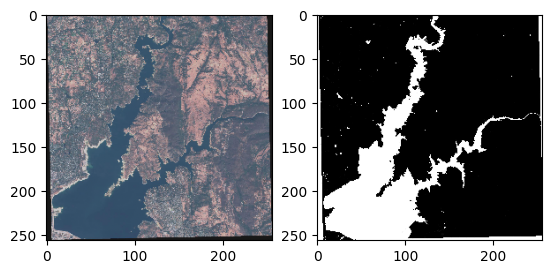

In [15]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

img, mask = train_dataset[seed]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)));

In [33]:
sample_num = 13
EPOCHS=50
BATCH_SIZE=32
LR=0.001

ratio=0.5

ENCODER='resnet50'
WEIGHTS='imagenet'

In [34]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [35]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.losses import JaccardLoss

In [36]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks != None:
            lossDice = DiceLoss(mode='binary')(logits,masks)
            return logits, lossDice
        return logits

In [37]:
model=SegmentationModel()
model.to(device);

In [38]:
def train_fn(data_loader, model, optimizer, scheduler):
    model.train()
    total_diceloss = 0.0
    for images, masks in tqdm(data_loader):
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        logits, diceloss = model(images,masks)
        #diceloss.backward(retain_graph=True)
        diceloss.backward()

        optimizer.step()

        total_diceloss += diceloss.item()

        scheduler.step()
        
    return total_diceloss/len(data_loader)

In [39]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            logits, diceloss= model(images, masks)
            total_diceloss += diceloss.item()
            
        #Visualization
        for i in range(1):
            image, mask = next(iter(valid_loader))
            image = image[sample_num]
            mask = mask[sample_num]
            logits_mask = model(image.to(device, dtype=torch.float32).unsqueeze(0))
            pred_mask = torch.sigmoid(logits_mask)
            pred_mask = (pred_mask > ratio) * 1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
            plt.show()
            
    return total_diceloss/len(data_loader)


In [40]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)

100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


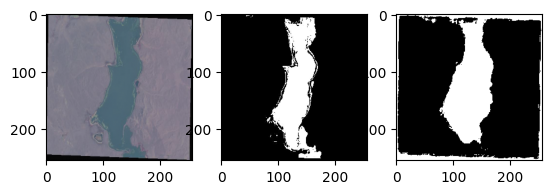

Epochs:1
Train_loss --> Dice: 0.4020442269742489 
Valid_loss --> Dice: 0.35367616017659503
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.09it/s]


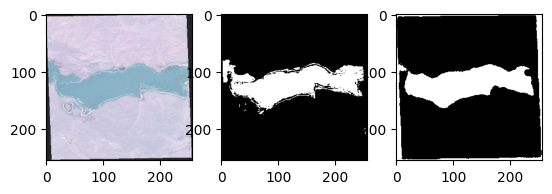

Epochs:2
Train_loss --> Dice: 0.30838814824819566 
Valid_loss --> Dice: 0.2825295196639167
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


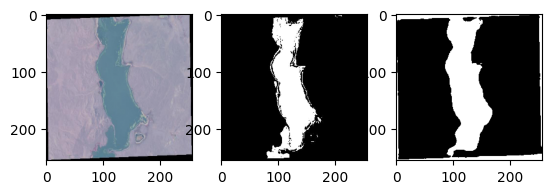

Epochs:3
Train_loss --> Dice: 0.26977924928069114 
Valid_loss --> Dice: 0.2528626587655809
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


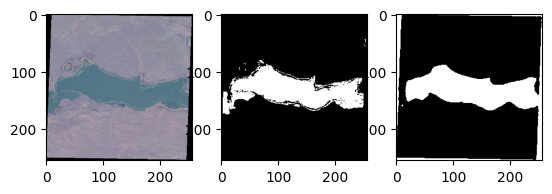

Epochs:4
Train_loss --> Dice: 0.22958984449505807 
Valid_loss --> Dice: 0.20925250980589125
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


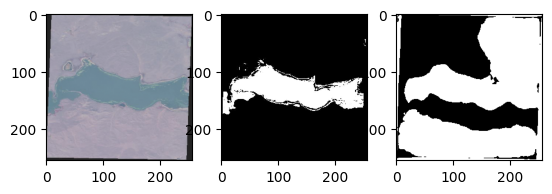

Epochs:5
Train_loss --> Dice: 0.1972102217376232 
Valid_loss --> Dice: 0.21392499738269383


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


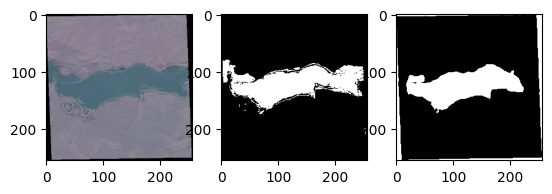

Epochs:6
Train_loss --> Dice: 0.18830877915024757 
Valid_loss --> Dice: 0.20150185293621486
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


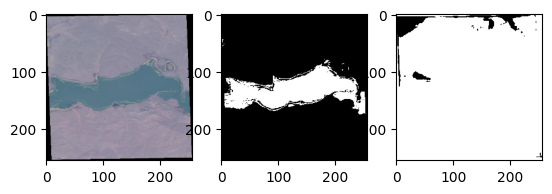

Epochs:7
Train_loss --> Dice: 0.20317025408148764 
Valid_loss --> Dice: 0.47513580322265625


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


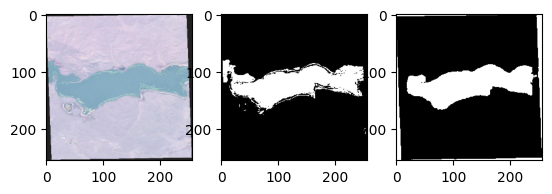

Epochs:8
Train_loss --> Dice: 0.19915002286434175 
Valid_loss --> Dice: 0.17840896050135294
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


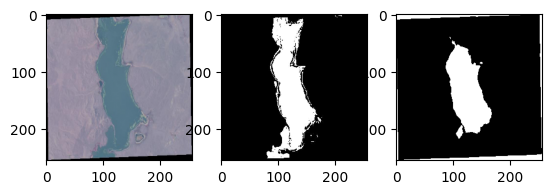

Epochs:9
Train_loss --> Dice: 0.1781314104795456 
Valid_loss --> Dice: 0.19387398825751412


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


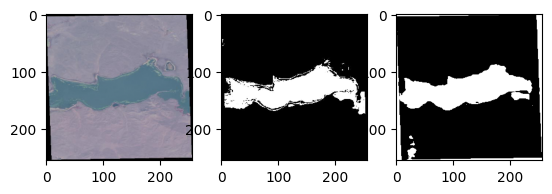

Epochs:10
Train_loss --> Dice: 0.19812213629484177 
Valid_loss --> Dice: 0.19763384262720743


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


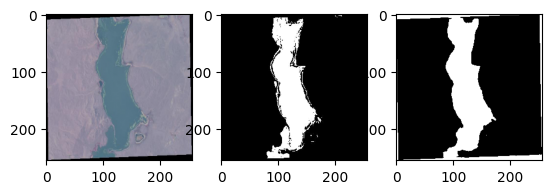

Epochs:11
Train_loss --> Dice: 0.17944097891449928 
Valid_loss --> Dice: 0.1757049626774258
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


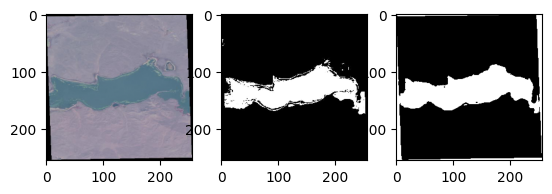

Epochs:12
Train_loss --> Dice: 0.168726197630167 
Valid_loss --> Dice: 0.1979683968755934


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


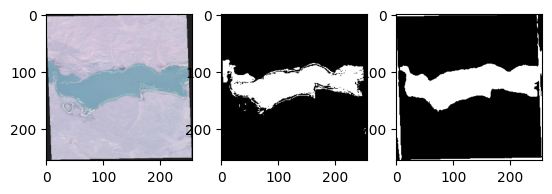

Epochs:13
Train_loss --> Dice: 0.1749659575521946 
Valid_loss --> Dice: 0.2194936474164327


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


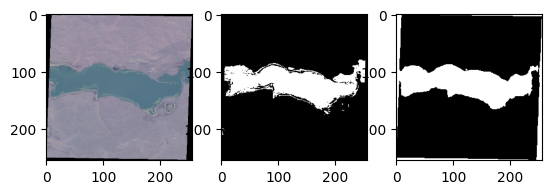

Epochs:14
Train_loss --> Dice: 0.1755496822297573 
Valid_loss --> Dice: 0.18956579764684042


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


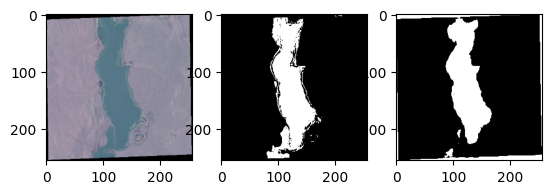

Epochs:15
Train_loss --> Dice: 0.16285096108913422 
Valid_loss --> Dice: 0.1661039392153422
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


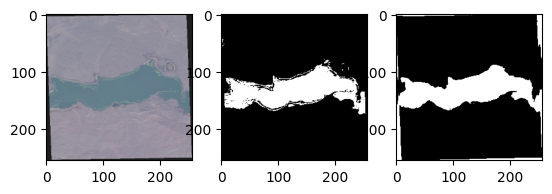

Epochs:16
Train_loss --> Dice: 0.15788003131747247 
Valid_loss --> Dice: 0.1516296002599928
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


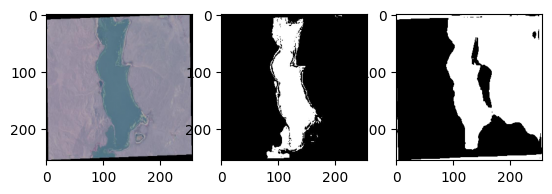

Epochs:17
Train_loss --> Dice: 0.15453880727291108 
Valid_loss --> Dice: 0.18449421061409843


100%|██████████| 9/9 [00:09<00:00,  1.03s/it]


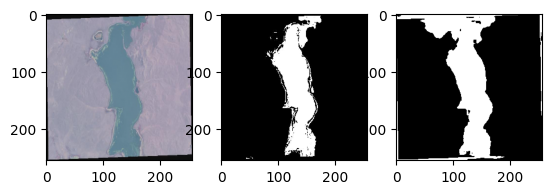

Epochs:18
Train_loss --> Dice: 0.1623385339975357 
Valid_loss --> Dice: 0.16884218984180027


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


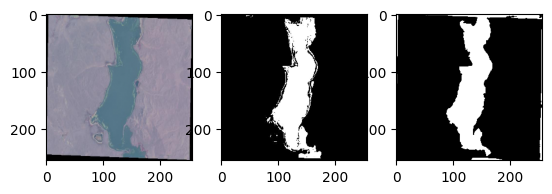

Epochs:19
Train_loss --> Dice: 0.15739653632044792 
Valid_loss --> Dice: 0.16663037406073677


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


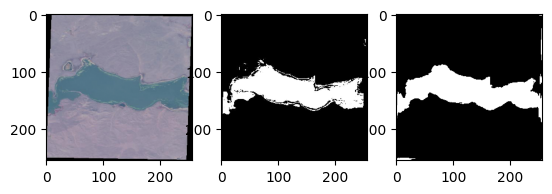

Epochs:20
Train_loss --> Dice: 0.14750530943274498 
Valid_loss --> Dice: 0.16640479697121513


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


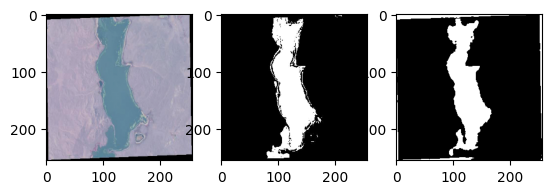

Epochs:21
Train_loss --> Dice: 0.15621042475104333 
Valid_loss --> Dice: 0.15323307116826376


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


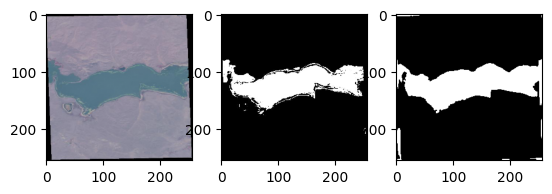

Epochs:22
Train_loss --> Dice: 0.15021901726722717 
Valid_loss --> Dice: 0.1465873122215271
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


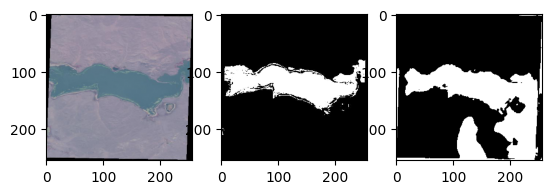

Epochs:23
Train_loss --> Dice: 0.1475762277841568 
Valid_loss --> Dice: 0.2017156415515476


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


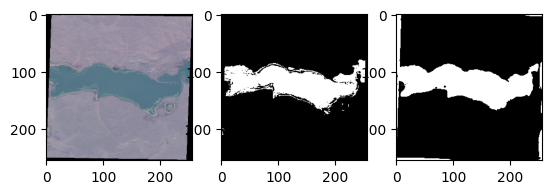

Epochs:24
Train_loss --> Dice: 0.14348055198788642 
Valid_loss --> Dice: 0.14647586478127372
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


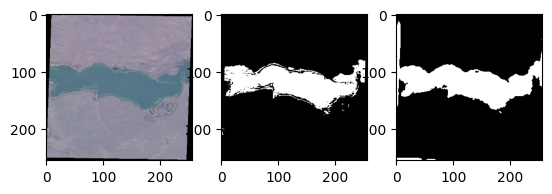

Epochs:25
Train_loss --> Dice: 0.13571148589253426 
Valid_loss --> Dice: 0.13502980603112114
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


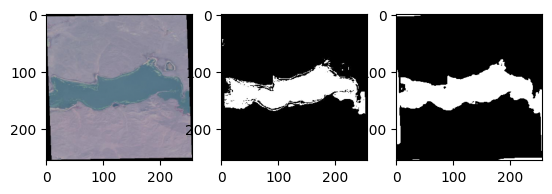

Epochs:26
Train_loss --> Dice: 0.13544967994093896 
Valid_loss --> Dice: 0.14060335689120823


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


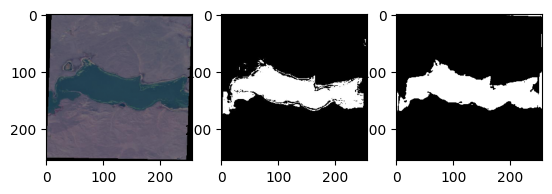

Epochs:27
Train_loss --> Dice: 0.13484086617827415 
Valid_loss --> Dice: 0.1457834111319648


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


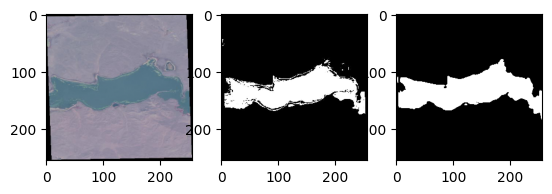

Epochs:28
Train_loss --> Dice: 0.13353773951530457 
Valid_loss --> Dice: 0.13859831624560887


100%|██████████| 9/9 [00:09<00:00,  1.05s/it]


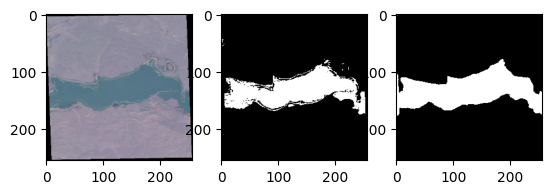

Epochs:29
Train_loss --> Dice: 0.12765832245349884 
Valid_loss --> Dice: 0.13108569383621216
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


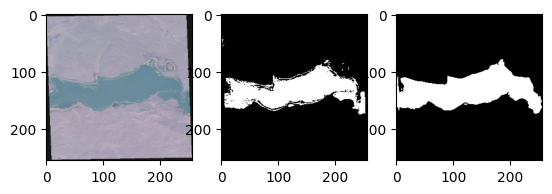

Epochs:30
Train_loss --> Dice: 0.12253443002700806 
Valid_loss --> Dice: 0.13565483358171251


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


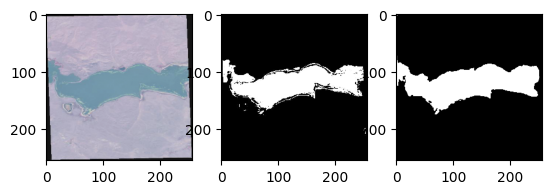

Epochs:31
Train_loss --> Dice: 0.13273297399282455 
Valid_loss --> Dice: 0.1311329205830892


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


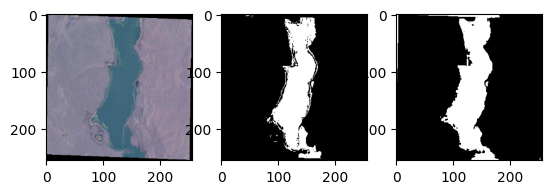

Epochs:32
Train_loss --> Dice: 0.12292750999331474 
Valid_loss --> Dice: 0.12879592180252075
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


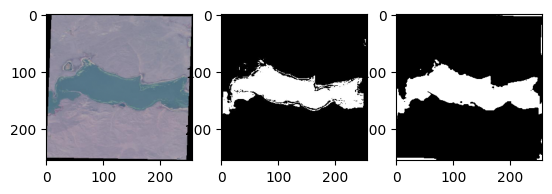

Epochs:33
Train_loss --> Dice: 0.12563678994774818 
Valid_loss --> Dice: 0.146942224767473


100%|██████████| 9/9 [00:09<00:00,  1.01s/it]


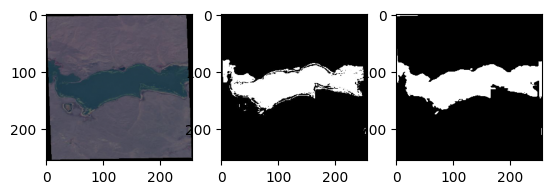

Epochs:34
Train_loss --> Dice: 0.13375215232372284 
Valid_loss --> Dice: 0.12546097569995457
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


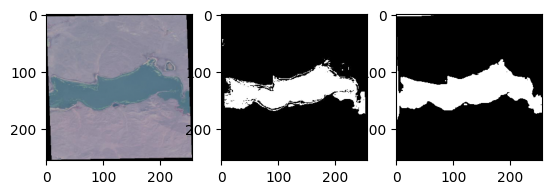

Epochs:35
Train_loss --> Dice: 0.125279251486063 
Valid_loss --> Dice: 0.1291952066951328


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


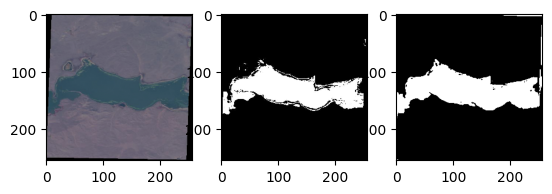

Epochs:36
Train_loss --> Dice: 0.11929318457841873 
Valid_loss --> Dice: 0.13932244645224678


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


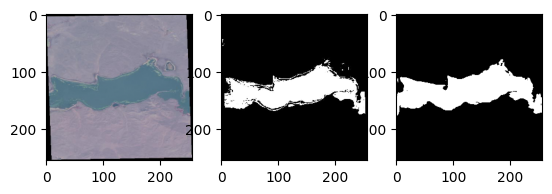

Epochs:37
Train_loss --> Dice: 0.1175195336341858 
Valid_loss --> Dice: 0.12210061815049914
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


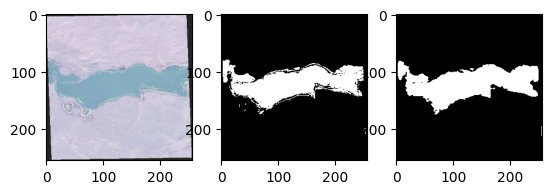

Epochs:38
Train_loss --> Dice: 0.11260521560907363 
Valid_loss --> Dice: 0.12331107589933607


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


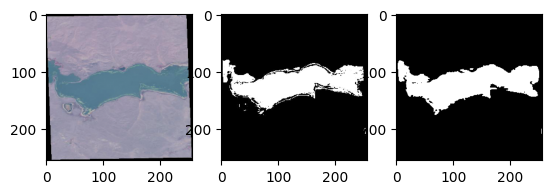

Epochs:39
Train_loss --> Dice: 0.11122763603925705 
Valid_loss --> Dice: 0.12305706077151829


100%|██████████| 9/9 [00:08<00:00,  1.02it/s]


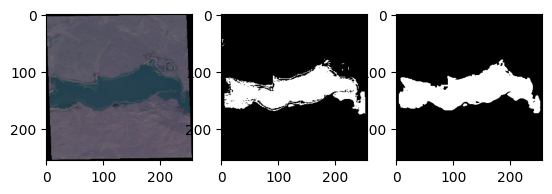

Epochs:40
Train_loss --> Dice: 0.1108506128191948 
Valid_loss --> Dice: 0.12342908647325304


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


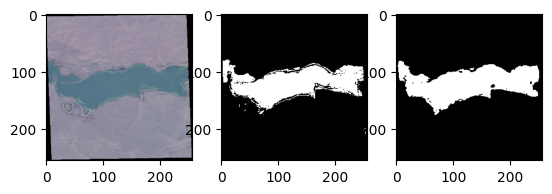

Epochs:41
Train_loss --> Dice: 0.10707639381289483 
Valid_loss --> Dice: 0.12024630440606011
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


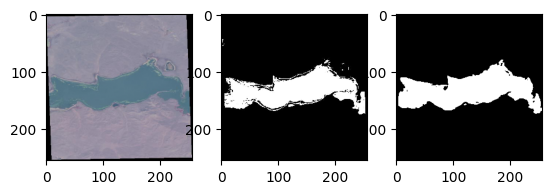

Epochs:42
Train_loss --> Dice: 0.1055029198527336 
Valid_loss --> Dice: 0.12249771091673109


100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


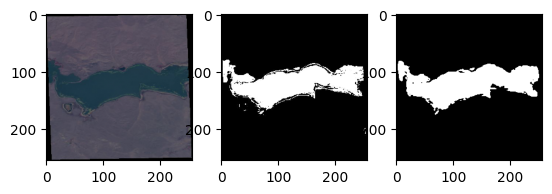

Epochs:43
Train_loss --> Dice: 0.1034184642136097 
Valid_loss --> Dice: 0.11833662456936306
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


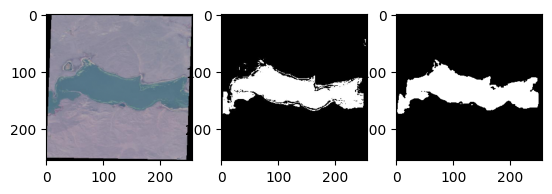

Epochs:44
Train_loss --> Dice: 0.10268867462873459 
Valid_loss --> Dice: 0.11882522371080187


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


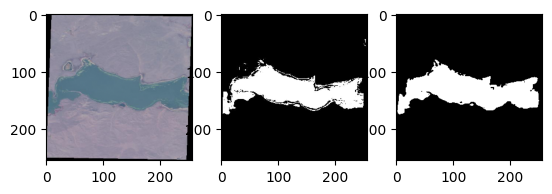

Epochs:45
Train_loss --> Dice: 0.10209622904658318 
Valid_loss --> Dice: 0.11411486069361369
Model Saved


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


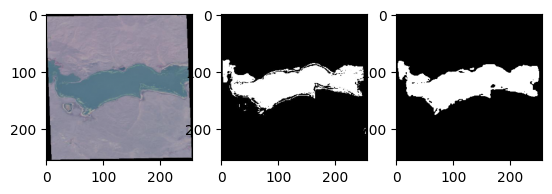

Epochs:46
Train_loss --> Dice: 0.09969086796045304 
Valid_loss --> Dice: 0.11452517906824748


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


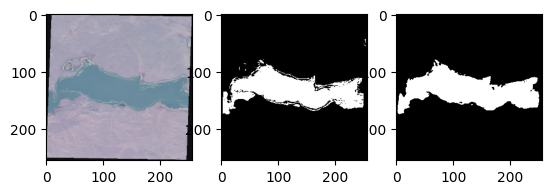

Epochs:47
Train_loss --> Dice: 0.10313091352581978 
Valid_loss --> Dice: 0.11577911509407891


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


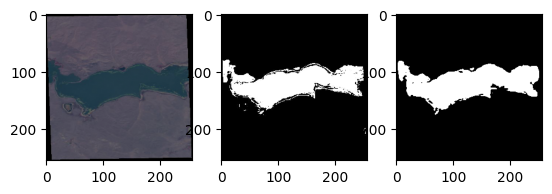

Epochs:48
Train_loss --> Dice: 0.10057067796587944 
Valid_loss --> Dice: 0.11326638195249769
Model Saved


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


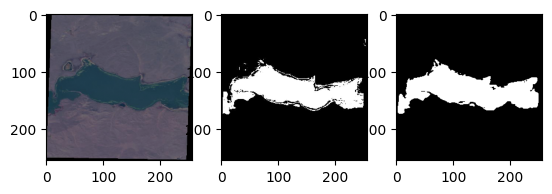

Epochs:49
Train_loss --> Dice: 0.09862791076302528 
Valid_loss --> Dice: 0.1132064660390218
Model Saved


100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


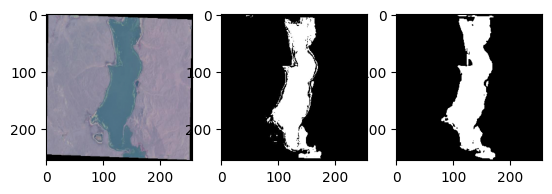

Epochs:50
Train_loss --> Dice: 0.0998226098716259 
Valid_loss --> Dice: 0.11561155981487697


In [41]:
best_val_dice_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, scheduler)
    valid_loss = eval_fn(valid_loader, model)

    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_loss} \nValid_loss --> Dice: {valid_loss}')
    
    if valid_loss < best_val_dice_loss:
        torch.save(model.state_dict(),'best_model_unet_resnet50.pt')
        print('Model Saved')
        best_val_dice_loss = valid_loss

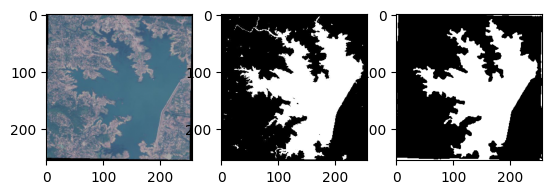

In [60]:
num = 18
ratio = 0.5

model.load_state_dict(torch.load('./best_model_unet_resnet50.pt'))

image, mask = next(iter(valid_loader))
image = image[num]
mask = mask[num]
logits_mask = model(image.to(device, dtype=torch.float32).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > ratio) * 1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray');